## Imports

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
sympy.init_printing()
from sympy import *
from functools import reduce
import string

## Functions

In [2]:
def plot_polygon(poly: sympy.Polygon, labels = []):
    # Draw a polygon by plotting vertices as points and edges as lines
    fig = plt.figure()
    ax = fig.gca()

    verts = poly.vertices

    for i, p in enumerate(verts):
        ax.scatter(p.x, p.y, c="r")
        if labels:
            plt.text(p.x + 0.05, p.y + 0.05, f"{labels[i]}: ({p.x},{p.y})")
        else:
            plt.text(p.x + 0.05, p.y + 0.05, f"({p.x},{p.y})")

    for (p, nextp) in zip(verts, verts[1:] + verts[:1]):
        x = np.linspace(float(p.x), float(nextp.x), 100, dtype=float)
        y = np.linspace(float(p.y), float(nextp.y), 100, dtype=float)
        ax.plot(x, y, c="b")

    ax.axis("equal")

    plt.show()    

In [3]:
def generate_premise(lines: dict, traj_expr):
    lines_rel = make_relative(lines, traj_expr)
    premise = True
    for line_rel in lines_rel.values():
        premise &= line_rel
    return premise

def generate_explicit(corner_pairs: list, traj, verts):
    explicit = False
    for c1, c2 in corner_pairs:
        corner_traj_1 = expand(traj.subs(y, yo - verts[c1].y).subs(x, xo - verts[c1].x))
        corner_traj_2 = expand(traj.subs(y, yo - verts[c2].y).subs(x, xo - verts[c2].x))
        pair_clause = corner_traj_1 * corner_traj_2 <= 0
        explicit |= pair_clause
    return explicit

def generate_explicit_disjunction(corner_pairs: list, traj, verts):
    explicit = False
    for c1, c2 in corner_pairs:
        corner_traj_1 = expand(traj.subs(y, yo - verts[c1].y).subs(x, xo - verts[c1].x))
        corner_traj_2 = expand(traj.subs(y, yo - verts[c2].y).subs(x, xo - verts[c2].x))
        pair_clause = ((corner_traj_1 <= 0) & (corner_traj_2 >= 0)) | ((corner_traj_1 >= 0) & (corner_traj_2 <= 0))
        explicit |= pair_clause
    return explicit

def sympy_to_pvs(clause: str):
    if type(clause) is not str:
        clause = str(clause)
    return clause.replace("x_O", "xo").replace("y_O", "yo").replace("|", "OR\n   ").replace("&", "AND\n    ").replace("**", "^")

def construct_lemma(premise, active_corner_condition, lemma_name):
    return f"""{lemma_name}(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ({sympy_to_pvs(str(premise))})
    IMPLIES
    {sympy_to_pvs(str(active_corner_condition))}
    """

def full_lemma(poly, vert_names, corner_pairs, traj, traj_expr=None, lemma_name="Soundness", disjunction=False):
    if type(vert_names) is str:
        vert_names = vert_names.split()
    assert type(vert_names) is list
    verts, lines = verts_and_lines(vert_names, poly)
    
    premise = generate_premise(lines, traj_expr)
    if disjunction:
        explicit = generate_explicit_disjunction(corner_pairs, traj, verts)        
    else:
        explicit = generate_explicit(corner_pairs, traj, verts)
    return construct_lemma(premise, explicit, lemma_name)

In [4]:
def build_line(x, y, coefs):
    return x*coefs[0] + y*coefs[1] + coefs[2]

def make_relative(expr, traj_expr):
    if type(expr) == dict:
        return make_relative_dict(expr, traj_expr)
    if traj_expr is None:
        return expr.subs(x, xo - x).subs(y, yo - alpha*x)
    else:
        return expr.subs(x, xo - x).subs(y, yo - traj_expr)

def make_relative_dict(d, te):
    return {k:make_relative(v, te) for k, v in d.items()}

In [5]:
def verts_and_lines(vert_names: list[str], poly: Polygon):
    assert len(vert_names) == len(poly.vertices)
    verts: dict = dict(zip(vert_names, poly.vertices))
    vert_names = sorted(vert_names)
    vert_pairs: list = list(zip(vert_names, vert_names[1:] + vert_names[0:1]))  
    lines: dict = {}
    for i, (vert1, vert2) in enumerate(vert_pairs, 1):
        line = build_line(x, y, Line(verts[vert1], verts[vert2]).coefficients)
        # sub in (0,0) to find inequality direction
        if (line >= 0).subs([(x,0), (y,0)]):
            lines[i] = line >= 0
        else:
            lines[i] = line <= 0
    return verts, lines

In [6]:
x, y = symbols("x y")
x, y

In [7]:
xo, yo, alpha = symbols(["x_O", "y_O", "alpha"])
xo, yo, alpha

## Experimentation

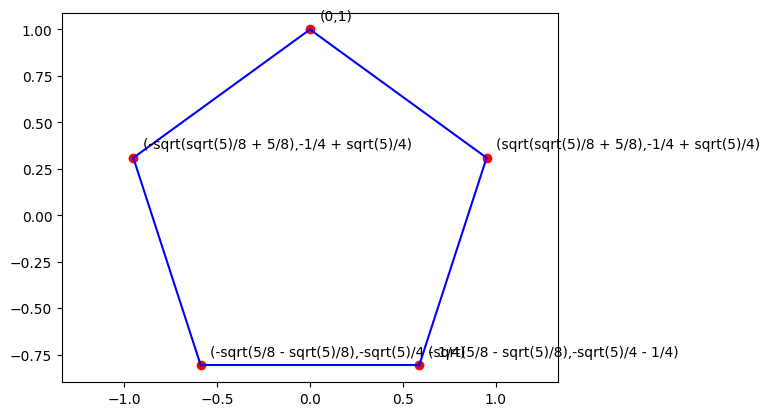

In [8]:
regpent = sympy.RegularPolygon(Point2D(0, 0), 1, 5, pi/2)
plot_polygon(regpent)

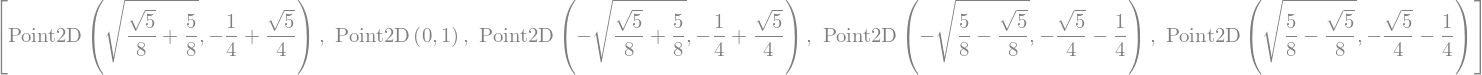

In [9]:
regpent.vertices

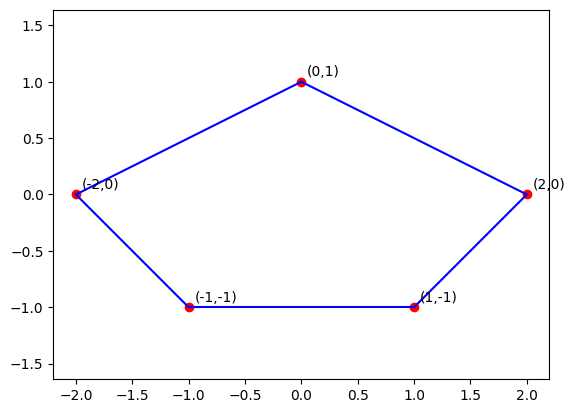

In [10]:
intvertices = [(1, -1), (2, 0), (0, 1), (-2, 0), (-1, -1)]
easypent = Polygon(*intvertices)
plot_polygon(easypent)

In [11]:
verts, lines = verts_and_lines("a b c d e".split(), easypent)
make_relative(lines)

TypeError: make_relative() missing 1 required positional argument: 'traj_expr'

In [ ]:
print(full_lemma(easypent, 
                 "b c d e a".split(), 
                 [('a', 'c'), ('a', 'd'), ('b', 'd'), ('b', 'e'), ('c', 'e')], 
                 y - alpha*x))

In [ ]:
simplify(expand((2*yo + xo - 2)*(2*alpha - 1) >= (2*yo - xo -2) * (2*alpha+1)))

In [ ]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
square.vertices

In [ ]:
vertex_dict = dict(zip("b c d a".split(), square.vertices))
vertex

In [ ]:
verts, lines = verts_and_lines("b c d a".split(), square)
verts

In [ ]:
lines

In [ ]:
lines_rel = make_relative(lines)
lines_rel

In [ ]:
print(full_lemma(square, "b c d a".split(), [('a', 'c'), ('b', 'd')], y - alpha*x))

In [ ]:
solve(lines_rel[4], x)

In [ ]:
# def solve_lines(lines: dict):
#     newlines = {}
#     for k in lines.keys():
#         newlines[k] = 

In [ ]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

In [ ]:
diamond = RegularPolygon(Point2D(0, 0), 1, 4, pi/2)
plot_polygon(diamond, "a b c d".split())
diamond.vertices

In [ ]:
print(full_lemma(diamond, "a b c d".split(), [('a', 'c'), ('b', 'd')], y - alpha*x))

In [ ]:
verts, lines = verts_and_lines("a b c d".split(), diamond)
verts

In [ ]:
lines

In [ ]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

In [ ]:
plot_polygon(regpent, "b c d e a".split())

In [ ]:
print(full_lemma(regpent, "b c d e a".split(), [('a', 'c'), ('a', 'd'), ('b', 'd'), ('b', 'e'), ('c', 'e')], y - alpha*x))

In [ ]:
verts, lines = verts_and_lines("b c d e a".split(), regpent)
verts

In [ ]:
lines

In [ ]:
plot_implicit(reduce(lambda x, y: x & y, lines.values()))

In [ ]:
simplify(lines[1])

In [ ]:
(5 - sqrt(5))/4 == -sqrt(5) / 2

In [ ]:
verts: dict = dict(zip("b c d e a".split(), regpent.vertices))
verts

In [ ]:
Line(verts["a"], verts['b']).equation()

In [ ]:
vert_names = "a b c d e".split()
vert_names

In [ ]:
vert_pairs = list(zip(vert_names, vert_names[1:] + vert_names[0:1]))
vert_pairs

In [ ]:
lines: dict = {}
for i, (vert1, vert2) in enumerate(vert_pairs, 1):
    lines[i] = build_line(x, y, Line(verts[vert1], verts[vert2]).coefficients)
lines

In [ ]:
line_e = build_line(x, y, Line(verts[-1], verts[-2]).coefficients)
line_e

In [ ]:
line_e_relative = line_e.subs("x", xo - x).subs("y", yo - alpha*x)
line_e_relative

In [ ]:
solveset(line_e_relative, x)

In [ ]:
linea = build_line(x, y, Line(verts[0], verts[-1]).coefficients)
linea

In [ ]:
linea_relative = linea.subs("x", xo - x).subs("y", yo - alpha*x)
linea_relative

In [ ]:
solveset(linea_relative, x)

In [ ]:
# picking this yields some coords = 0 or 1 but others are even worse
scaling = 1 / sqrt(sqrt(5)/8 + 5/8 )
scaling

In [ ]:
unitpent = sympy.RegularPolygon(Point2D(0, 0), scaling, 5, pi/2)
unitpent

In [ ]:
unitpent.vertices

In [ ]:
plot_polygon(unitpent)

In [ ]:
verts = unitpent.vertices
simplify(Line(verts[0], verts[-1]).equation())

In [ ]:
unithex = sympy.RegularPolygon(Point2D(0, 0), 2, 6, 0)
plot_polygon(unithex)

## Building PVS Lemma

target code:

    SoundnessAlpha(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((xo - x) <= 1 AND (xo - x) >= -1 AND
    (yo - alpha*x) <= 1 AND (yo - alpha*x) >= -1))
    IMPLIES
    ((yo - alpha*xo - alpha - 1) *
    (yo - alpha*xo + alpha + 1) <= 0) OR
    ((yo - alpha*xo - alpha + 1) *
    (yo - alpha*xo + alpha - 1) <= 0)
    OR inactive_case 
    
assume we get the pairs of active corners from the user     

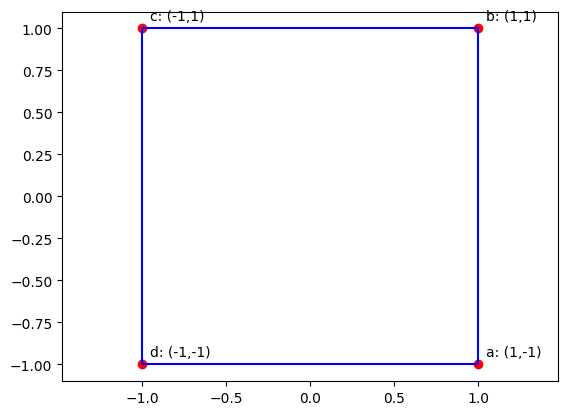

{'b': Point2D(1, 1),
 'c': Point2D(-1, 1),
 'd': Point2D(-1, -1),
 'a': Point2D(1, -1)}

In [12]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
square.vertices
verts, lines = verts_and_lines("b c d a".split(), square)
verts

In [13]:
lines

In [14]:
lines_rel = make_relative(lines)
lines_rel

TypeError: make_relative() missing 1 required positional argument: 'traj_expr'

In [ ]:
premise = True
for line_rel in lines_rel.values():
    premise &= line_rel
premise

In [ ]:
sympy_to_pvs(str(premise))

In [15]:
corner_pairs = [('a', 'c'), ('b', 'd')]

In [16]:
base_traj = y - alpha*x
base_traj

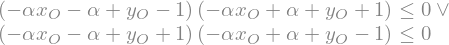

In [17]:
explicit = False
for c1, c2 in corner_pairs:
    corner_traj_1 = expand(base_traj.subs(y, yo - verts[c1].y).subs(x, xo - verts[c1].x))
    corner_traj_2 = expand(base_traj.subs(y, yo - verts[c2].y).subs(x, xo - verts[c2].x))
    pair_clause = corner_traj_1 * corner_traj_2 <= 0
    explicit |= pair_clause
explicit

In [18]:
str(explicit)

'((-alpha*x_O - alpha + y_O - 1)*(-alpha*x_O + alpha + y_O + 1) <= 0) | ((-alpha*x_O - alpha + y_O + 1)*(-alpha*x_O + alpha + y_O - 1) <= 0)'

In [19]:
sympy_to_pvs(clause)

NameError: name 'clause' is not defined

In [ ]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x

In [ ]:
print(full_lemma(square, vert_names, corner_pairs, traj))

In [ ]:
print(construct_lemma(premise, explicit, "SoundnessSquare"))

## Hexagon

In [ ]:
hexagon = RegularPolygon(Point2D(0, 0), sqrt(3), 6, 0)
plot_polygon(hexagon, "b c d e f a".split())
hexagon.vertices
verts, lines = verts_and_lines("b c d e f a".split(), hexagon)
verts

## Rectangle

In [ ]:
rectverts = [(2, -1), (2, 1), (-2, 1), (-2, -1)]
rect = Polygon(*rectverts)
plot_polygon(rect, "b c d a".split())

In [ ]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x

In [ ]:
# premise here - unsafe_impl, quantified
# basically says there's a point along trajectory (x, alpha*x) [more generally (x, f(x))]
# where intruder at some point (xo, yo) is within ALL four edges of the rectangle
# centered at (x, f(x)).
print(full_lemma(rect, vert_names, corner_pairs, traj))

## Diamond

In [ ]:
diamond = RegularPolygon(Point2D(0, 0), 1, 4, 0)
plot_polygon(diamond, "b c d a".split())
diamond.vertices
verts, lines = verts_and_lines("b c d a".split(), diamond)
verts

In [ ]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - x**2
traj_expr = x**2

In [ ]:
traj

note: are we missing the notch here???

In [ ]:
print(full_lemma(diamond, vert_names, corner_pairs, traj, traj_expr))

## Square

In [ ]:
square = RegularPolygon(Point2D(0, 0), sqrt(2), 4, pi/4)
plot_polygon(square, "b c d a".split())
verts, lines = verts_and_lines("b c d a".split(), square)
verts

In [ ]:
vert_names = "b c d a".split()
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - alpha*x
traj_expr = alpha*x

In [ ]:
print(full_lemma(square, vert_names, corner_pairs, traj, traj_expr))

# Imports

In [2]:
import sys
import os
import string 
from sympy import expand, Line, Polygon, symbols, Point, Function, diff, Symbol, solve, Eq, plot, Piecewise, latex

x, y, xo, yo, alpha = symbols("x y x_O y_O \alpha")

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from pvs_utils import *

# General function $f(x)$

## Rectangle

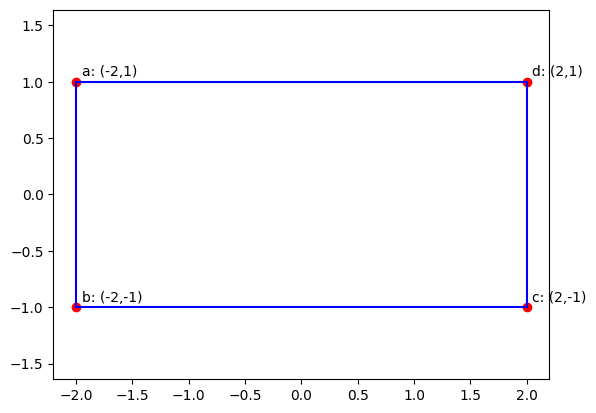

{'b': Point2D(-2, -1),
 'c': Point2D(2, -1),
 'd': Point2D(2, 1),
 'a': Point2D(-2, 1)}

In [7]:
vertices = [(-2, -1), (2, -1), (2, 1), (-2, 1)]
labels = string.ascii_lowercase[:len(vertices)]
labels = list(labels[1:] + labels[:1])
rect = Polygon(*[Point(v) for v in vertices])
plot_polygon(rect, labels)
verts, lines = verts_and_lines(labels, rect)
verts

In [8]:
corner_pairs = [('a', 'c'), ('b', 'd')]
f = Function('f')(x)
traj = y - f
traj_expr = f

In [9]:
print(full_lemma(rect, labels, corner_pairs, traj, traj_expr, disjunction=True))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (yo - f(x) + 1 >= 0) AND
     (yo - f(x) - 1 <= 0))
    IMPLIES
    ((yo - f(xo - 2) - 1 >= 0) AND
     (yo - f(xo + 2) + 1 <= 0)) OR
    ((yo - f(xo - 2) + 1 >= 0) AND
     (yo - f(xo + 2) - 1 <= 0)) OR
    ((yo - f(xo + 2) - 1 >= 0) AND
     (yo - f(xo - 2) + 1 <= 0)) OR
    ((yo - f(xo + 2) + 1 >= 0) AND
     (yo - f(xo - 2) - 1 <= 0))
    


## Triangle with slope 1

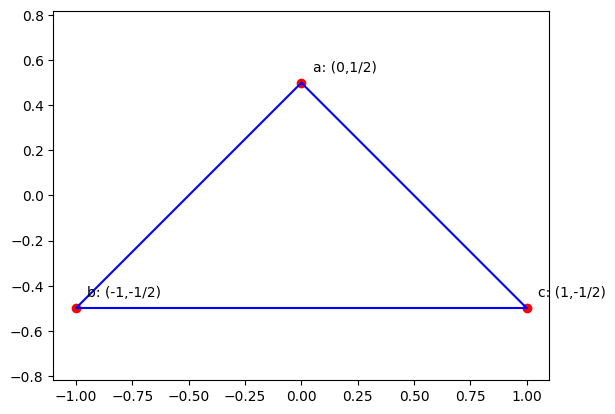

{'b': Point2D(-1, -1/2), 'c': Point2D(1, -1/2), 'a': Point2D(0, 1/2)}

In [6]:
vertices = [(-1, -0.5), (1, -0.5), (0, 0.5)]
labels = string.ascii_lowercase[:len(vertices)]
labels = list(labels[1:] + labels[:1])
triangle = Polygon(*[Point(v) for v in vertices])
plot_polygon(triangle, labels)
verts, lines = verts_and_lines(labels, triangle)
verts

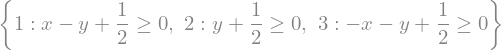

In [85]:
lines

In [86]:
corner_pairs = [('a', 'b'), ('a', 'c'), ('b', 'c')]
f = Function('f')(x)
traj = y - f
traj_expr = f

In [87]:
print(full_lemma(triangle, labels, corner_pairs, traj, traj_expr, disjunction=True))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((yo - f(x) + 1/2 >= 0) AND
     (-x + xo - yo + f(x) + 1/2 >= 0) AND
     (x - xo - yo + f(x) + 1/2 >= 0))
    IMPLIES
    ((yo - f(xo) - 1/2 >= 0) AND
     (yo - f(xo - 1) + 1/2 <= 0)) OR
    ((yo - f(xo) - 1/2 >= 0) AND
     (yo - f(xo + 1) + 1/2 <= 0)) OR
    ((yo - f(xo) - 1/2 <= 0) AND
     (yo - f(xo - 1) + 1/2 >= 0)) OR
    ((yo - f(xo) - 1/2 <= 0) AND
     (yo - f(xo + 1) + 1/2 >= 0)) OR
    ((yo - f(xo - 1) + 1/2 >= 0) AND
     (yo - f(xo + 1) + 1/2 <= 0)) OR
    ((yo - f(xo + 1) + 1/2 >= 0) AND
     (yo - f(xo - 1) + 1/2 <= 0))
    


In [88]:
# TODO rewrite lemma structure to match what we have in existing proofs
# split the multiplication into ANDS? 

# TODO what about mvt-gen-le, do we need this
# TODO endpoint proof cases, regions of X for which 
# TODO generic triangle? 
# TODO square

# tanner missing an assumption 


## Triangle with slope 2

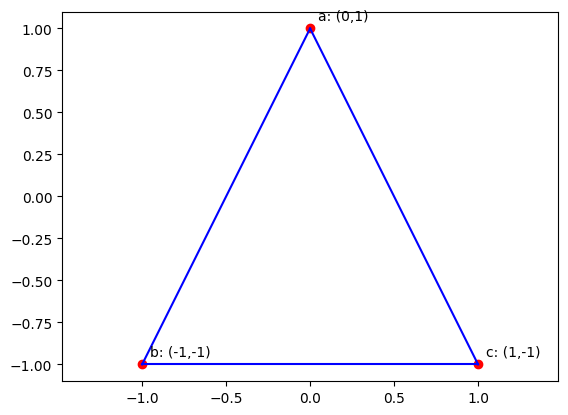

{'b': Point2D(-1, -1), 'c': Point2D(1, -1), 'a': Point2D(0, 1)}

In [89]:
vertices = [(-1, -1), (1, -1), (0, 1)]
labels = string.ascii_lowercase[:len(vertices)]
labels = list(labels[1:] + labels[:1])
triangle = Polygon(*[Point(v) for v in vertices])
plot_polygon(triangle, labels)
verts, lines = verts_and_lines(labels, triangle)
verts

In [90]:
lines

In [91]:
corner_pairs = [('a', 'b'), ('a', 'c'), ('b', 'c')]
f = Function('f')(x)
traj = y - f
traj_expr = f

In [92]:
print(full_lemma(triangle, labels, corner_pairs, traj, traj_expr, disjunction=True))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((yo - f(x) + 1 >= 0) AND
     (-2*x + 2*xo - yo + f(x) + 1 >= 0) AND
     (2*x - 2*xo - yo + f(x) + 1 >= 0))
    IMPLIES
    ((yo - f(xo) - 1 >= 0) AND
     (yo - f(xo - 1) + 1 <= 0)) OR
    ((yo - f(xo) - 1 >= 0) AND
     (yo - f(xo + 1) + 1 <= 0)) OR
    ((yo - f(xo) - 1 <= 0) AND
     (yo - f(xo - 1) + 1 >= 0)) OR
    ((yo - f(xo) - 1 <= 0) AND
     (yo - f(xo + 1) + 1 >= 0)) OR
    ((yo - f(xo - 1) + 1 >= 0) AND
     (yo - f(xo + 1) + 1 <= 0)) OR
    ((yo - f(xo + 1) + 1 >= 0) AND
     (yo - f(xo - 1) + 1 <= 0))
    


In [93]:
quad = x ** 2 + 2*x + 3
quad

In [94]:
diff(quad, x)

In [95]:
diff(quad, x).subs(x, Symbol("a"))

In [96]:
solve(Eq(diff(x ** 2 + 2*x + 3, x), 0)) # 1 here is slope of side of some polygon

## Parabola then straight

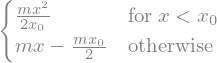

In [97]:
# Define variables
x, a, m, x0, d = symbols('x a m x0 d')

# Parabola and line equations
parabola = a * x**2
line = m * x + d

# Solve for continuity and smoothness at x0
value_match = Eq(a * x0**2, m * x0 + d)
derivative_match = Eq(2 * a * x0, m)

# Solve for a and d
solutions = solve([value_match, derivative_match], (a, d))

# Substitute the solutions back
parabola_smooth = parabola.subs(solutions)
line_smooth = line.subs(solutions)

# Define the piecewise function
piecewise_function = Piecewise((parabola_smooth, x < x0), (line_smooth, x >= x0))

piecewise_function

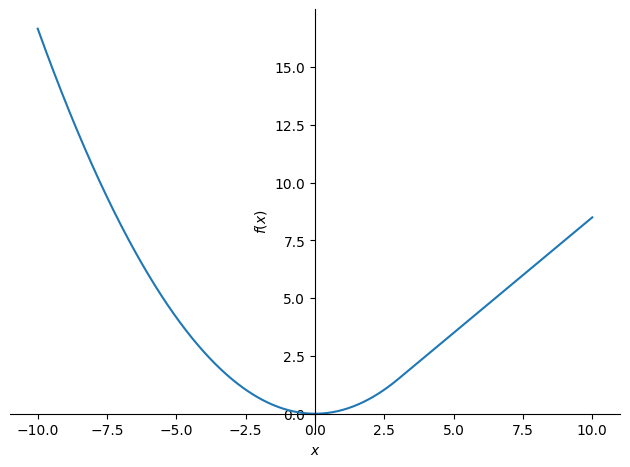

In [98]:
plot(piecewise_function.subs({m: 1, x0: 3}))

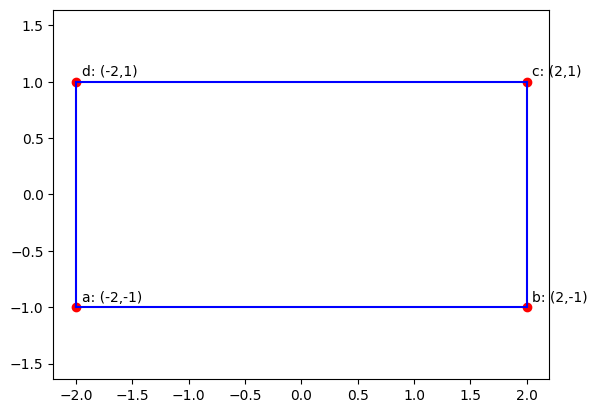

In [99]:
w, h = symbols("w h")

rectverts = [(w, -h), (w, h), (-w, h), (-w, -h)]
w = 2 
h = 1
rectverts = [(w, -h), (w, h), (-w, h), (-w, -h)]
rect = Polygon(*rectverts)
plot_polygon(rect, "b c d a".split())
labels = string.ascii_lowercase[:len(rectverts)]
labels = list(labels[1:] + labels[:1])

In [100]:
verts, lines = verts_and_lines(labels, rect)

In [101]:
corner_pairs = [('a', 'c'), ('b', 'd')]
traj = y - piecewise_function
traj_expr = piecewise_function

In [102]:
print(full_lemma(rect, labels, corner_pairs, traj, traj_expr, disjunction=True))

Soundness(xo, yo, alpha: real) : bool =
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (yo - Piecewise((m*x^2/(2*x0), x < x0), (m*x - m*x0/2, True)) + 1 >= 0) AND
     (yo - Piecewise((m*x^2/(2*x0), x < x0), (m*x - m*x0/2, True)) - 1 <= 0))
    IMPLIES
    ((yo - Piecewise((m*xo^2/(2*x0) - 2*m*xo/x0 + 2*m/x0, x0 > xo - 2), (-m*x0/2 + m*xo - 2*m, True)) - 1 >= 0) AND
     (yo - Piecewise((m*xo^2/(2*x0) + 2*m*xo/x0 + 2*m/x0, x0 > xo + 2), (-m*x0/2 + m*xo + 2*m, True)) + 1 <= 0)) OR
    ((yo - Piecewise((m*xo^2/(2*x0) - 2*m*xo/x0 + 2*m/x0, x0 > xo - 2), (-m*x0/2 + m*xo - 2*m, True)) + 1 >= 0) AND
     (yo - Piecewise((m*xo^2/(2*x0) + 2*m*xo/x0 + 2*m/x0, x0 > xo + 2), (-m*x0/2 + m*xo + 2*m, True)) - 1 <= 0)) OR
    ((yo - Piecewise((m*xo^2/(2*x0) + 2*m*xo/x0 + 2*m/x0, x0 > xo + 2), (-m*x0/2 + m*xo + 2*m, True)) - 1 >= 0) AND
     (yo - Piecewise((m*xo^2/(2*x0) - 2*m*xo/x0 + 2*m/x0, x0 > xo - 2), (-m*x0/2 + m*xo - 2*m, True)) + 1 <= 0)) OR
    ((yo - P

In [103]:
print(latex(generate_explicit_disjunction(corner_pairs, traj, verts)))

\left(yo - \begin{cases} \frac{m xo^{2}}{2 x_{0}} - \frac{2 m xo}{x_{0}} + \frac{2 m}{x_{0}} & \text{for}\: x_{0} > xo - 2 \\- \frac{m x_{0}}{2} + m xo - 2 m & \text{otherwise} \end{cases} - 1 \geq 0 \wedge yo - \begin{cases} \frac{m xo^{2}}{2 x_{0}} + \frac{2 m xo}{x_{0}} + \frac{2 m}{x_{0}} & \text{for}\: x_{0} > xo + 2 \\- \frac{m x_{0}}{2} + m xo + 2 m & \text{otherwise} \end{cases} + 1 \leq 0\right) \vee \left(yo - \begin{cases} \frac{m xo^{2}}{2 x_{0}} - \frac{2 m xo}{x_{0}} + \frac{2 m}{x_{0}} & \text{for}\: x_{0} > xo - 2 \\- \frac{m x_{0}}{2} + m xo - 2 m & \text{otherwise} \end{cases} + 1 \geq 0 \wedge yo - \begin{cases} \frac{m xo^{2}}{2 x_{0}} + \frac{2 m xo}{x_{0}} + \frac{2 m}{x_{0}} & \text{for}\: x_{0} > xo + 2 \\- \frac{m x_{0}}{2} + m xo + 2 m & \text{otherwise} \end{cases} - 1 \leq 0\right) \vee \left(yo - \begin{cases} \frac{m xo^{2}}{2 x_{0}} + \frac{2 m xo}{x_{0}} + \frac{2 m}{x_{0}} & \text{for}\: x_{0} > xo + 2 \\- \frac{m x_{0}}{2} + m xo + 2 m & \text{otherwis

## Prooflite

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First Claude version

In [45]:
# class ProofNode:
#     def __init__(self, command, args=None):
#         self.command = command
#         self.args = args if args else []
#         self.children = []

#     def add_child(self, node):
#         self.children.append(node)
#         return node

#     def generate(self, indent="%|- "):
#         if not self.children:
#             cmd = f"({self.command}"
#             if self.args:
#                 cmd += " " + " ".join(str(arg) for arg in self.args)
#             return cmd + ")"

#         cmd = f"({self.command}"
#         if self.args:
#             cmd += " " + " ".join(str(arg) for arg in self.args)

#         if len(self.children) == 1:
#             cmd += " " + self.children[0].generate(indent).strip()
#             return cmd + ")"

#         child_proofs = [c.generate(indent) for c in self.children]
#         return f"{cmd}\n{indent} " + f"\n{indent} ".join(child_proofs) + ")"


# class ProofScript:
#     def __init__(self, lemma_name):
#         self.lemma_name = lemma_name
#         self.root = None

#     def generate(self):
#         lines = []
#         lines.append(f"%|- {self.lemma_name} : PROOF")
#         lines.append(f"%|- {self.root.generate()}")
#         lines.append(f"%|- QED {self.lemma_name}")
#         return "\n".join(lines)

class ProofNode:
    def __init__(self, command, args=None):
        self.command = command
        self.args = args if args else []
        self.children = []
        
    def add_child(self, node):
        self.children.append(node)
        return node
        
    def add_children(self, nodes):
        self.children.extend(nodes)
        return nodes
        
    def generate(self, indent="%|- ", depth=0):
        base_indent = indent + " " * depth
        
        # Base case - no children
        if not self.children:
            return f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''})"
            
        # Single child - keep on same line
        if len(self.children) == 1 and len(self.children[0].children) == 0:
            return f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''} {self.children[0].generate(indent, depth)})"
        
        # Multiple children or nested structures
        result = f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''}"
        
        child_proofs = [c.generate(indent, depth + 1) for c in self.children]
        child_str = f"\n{base_indent} ".join(child_proofs)
        
        return f"{result}\n{base_indent} {child_str})"

    
class ProofScript:
    def __init__(self, lemma_name):
        self.lemma_name = lemma_name
        self.root = None
        
    def generate(self):
        lines = []
        lines.append(f"%|- {self.lemma_name} : PROOF")
        lines.append(f"%|- {self.root.generate()}")
        lines.append(f"%|- QED {self.lemma_name}")
        return "\n".join(lines)

# Example usage:
def build_rect_proof(lemma_name, mvt_lemma, inst_terms):
    script = ProofScript(lemma_name)

    then = ProofNode("THEN")
    script.root = then

    then.add_child(ProofNode("SKEEP*"))
    then.add_child(ProofNode("LEMMA", [f'"{mvt_lemma}"']))
    then.add_child(ProofNode("INST?"))
    then.add_child(ProofNode("ASSERT"))

    spread = ProofNode("SPREAD")
    then.add_child(spread)

    split = ProofNode("SPLIT", ["-1"])
    spread.add_child(split)

    branch1 = ProofNode("THEN")
    branch1.add_child(ProofNode("ASSERT"))
    for i in range(len(inst_terms) - 1):
        branch1.add_child(
            ProofNode("INST", ["-1", f'"{inst_terms[i]}"', f'"{inst_terms[i+1]}"'])
        )
        branch1.add_child(ProofNode("ASSERT"))

    branch2 = ProofNode("PROPAX")

    spread.add_child(branch1)
    spread.add_child(branch2)

    return script


In [46]:
proof = build_rect_proof(
   "bound11_rect_function",
   "mvt_gen_ge", 
   ["xo + 2", "x", "xo - 2"]
)
print(proof.generate())

%|- bound11_rect_function : PROOF
%|- (THEN
%|-  (SKEEP*)
%|-  (LEMMA "mvt_gen_ge")
%|-  (INST?)
%|-  (ASSERT)
%|-  (SPREAD
%|-   (SPLIT -1)
%|-   (THEN
%|-    (ASSERT)
%|-    (INST -1 "xo + 2" "x")
%|-    (ASSERT)
%|-    (INST -1 "x" "xo - 2")
%|-    (ASSERT))
%|-   (PROPAX)))
%|- QED bound11_rect_function


In [47]:
def build_rect_proof(lemma_name, mvt_lemma, inst_terms):
    script = ProofScript(lemma_name)

    then = ProofNode("THEN")
    script.root = then

    then.add_child(ProofNode("SKEEP*"))
    then.add_child(ProofNode("LEMMA", [f'"{mvt_lemma}"']))
    then.add_child(ProofNode("INST?"))
    then.add_child(ProofNode("ASSERT"))

    spread1 = ProofNode("SPREAD")
    then.add_child(spread1)

    split1 = ProofNode("SPLIT", ["-1"])
    spread1.add_child(split1)

    # First branch
    branch1 = ProofNode("THEN")
    branch1.add_child(ProofNode("ASSERT"))
    branch1.add_child(ProofNode("INST", ["-1", f'"{inst_terms[0]}"', f'"{inst_terms[1]}"']))
    branch1.add_child(ProofNode("ASSERT"))
    branch1.add_child(ProofNode("LEMMA", [f'"{mvt_lemma}"']))
    branch1.add_child(ProofNode("INST?"))
    branch1.add_child(ProofNode("ASSERT"))

    # Nested spread
    spread2 = ProofNode("SPREAD")
    branch1.add_child(spread2)

    split2 = ProofNode("SPLIT", ["-1"]) 
    spread2.add_child(split2)

    # Inner branches
    inner_branch1 = ProofNode("THEN")
    inner_branch1.add_child(ProofNode("INST", ["-1", f'"{inst_terms[1]}"', f'"{inst_terms[2]}"']))
    inner_branch1.add_child(ProofNode("ASSERT"))

    inner_branch2 = ProofNode("PROPAX")

    # Structure the nested spread
    spread2.add_children([inner_branch1, inner_branch2]) 

    # Second main branch
    branch2 = ProofNode("PROPAX")

    # Structure the outer spread
    spread1.add_children([branch1, branch2])

    return script

In [48]:
proof = build_rect_proof(
    "bound12_rect_function",
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
)
print(proof.generate())

%|- bound12_rect_function : PROOF
%|- (THEN
%|-  (SKEEP*)
%|-  (LEMMA "mvt_gen_ge")
%|-  (INST?)
%|-  (ASSERT)
%|-  (SPREAD
%|-   (SPLIT -1)
%|-   (THEN
%|-    (ASSERT)
%|-    (INST -1 "xo + 2" "x")
%|-    (ASSERT)
%|-    (LEMMA "mvt_gen_ge")
%|-    (INST?)
%|-    (ASSERT)
%|-    (SPREAD
%|-     (SPLIT -1)
%|-     (THEN
%|-      (INST -1 "x" "xo - 2")
%|-      (ASSERT))
%|-     (PROPAX)))
%|-   (PROPAX)))
%|- QED bound12_rect_function


### Claude refactor

In [49]:
class ProofNode:
    def __init__(self, command, args=None):
        self.command = command
        self.args = args if args else []
        self.children = []
        
    def __repr__(self):
        args_str = f" {self.args}" if self.args else ""
        children_str = f" children={len(self.children)}" if self.children else ""
        return f"ProofNode({self.command}{args_str}{children_str})"

        
    def add_child(self, node):
        self.children.append(node)
        return node
        
    def add_children(self, nodes):
        self.children.extend(nodes)
        return nodes
            
    def generate(self, indent="%|- ", depth=0, n_spaces=4):
        if self.command == "()":  # Special handling for wrapper nodes
            # Generate children with extra parentheses
            child_proofs = [c.generate(indent, depth) for c in self.children]
            return f"({' '.join(child_proofs)})"
        base_indent = indent + " " * depth * n_spaces

        # Base case - no children
        if not self.children:
            return f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''})"

        # Multiple children or nested structures
        result = f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''}"

        child_proofs = [c.generate(indent, depth + 1) for c in self.children]
        child_str = f"\n{base_indent} ".join(child_proofs)

        return f"{result}\n{base_indent} {child_str})"
            

class ProofBuilder:
    def __init__(self):
        self.indent = "%|- "
        
    def __repr__(self):
        return f"ProofBuilder(indent='{self.indent}')"
        
        
    def create_then_sequence(self, *steps):
        then = ProofNode("THEN")
        for step in steps:
            if isinstance(step, list):
                for s in step:
                    then.add_child(s)
            else:
                then.add_child(step)
        return then

#     def create_spread_split(self, branches):
#         spread = ProofNode("SPREAD")
#         split = ProofNode("SPLIT", ["-1"])
#         spread.add_child(split)
        
#         # Add each branch within extra parentheses
#         for i, branch in enumerate(branches):
#             print(branch)
#             if i == 0:
#                 wrapper = ProofNode("()")  # Special node type for extra parentheses
#                 wrapper.add_children(branch)
#                 spread.add_child(wrapper)
#             else:
#                 spread.add_child(branch)
#         # for i, branch in enumerate(branches):
#         #     wrapper = ProofNode("()")  # Special node type for extra parentheses
#         #     wrapper.add_children(branch)
#         #     spread.add_child(wrapper)
#         return spread
        
    def create_spread_split(self, branches):
        spread = ProofNode("SPREAD")
        split = ProofNode("SPLIT", ["-1"])
        spread.add_child(split)

        # Remove extra list nesting for branches
        first_branch = branches[0][0]  # Extract from double list
        wrapper = ProofNode("()")
        wrapper.add_child(first_branch)
        spread.add_child(wrapper)

        # Add remaining branches directly
        for branch in branches[1:]:
            spread.add_child(branch[0])  # Extract from list

        return spread    
        
        
    def create_mvt_step(self, mvt_lemma):
        return [
            ProofNode("LEMMA", [f'"{mvt_lemma}"']),
            ProofNode("INST?"),
            ProofNode("ASSERT")
        ]
        
    def create_inst_step(self, term1, term2):
        return [
            ProofNode("INST", ["-1", f'"{term1}"', f'"{term2}"']),
            ProofNode("ASSERT")
        ]

    def build_rect_proof(self, lemma_name, mvt_lemma, inst_terms):
        script = ProofScript(lemma_name)
        
        root = self.create_then_sequence(
            ProofNode("SKEEP*"),
            *self.create_mvt_step(mvt_lemma)
        )
        
        # Inner branch with THEN sequence
        inner_then = self.create_then_sequence(
            *self.create_inst_step(inst_terms[1], inst_terms[2])
        )
        
        # Inner SPREAD with branches in list
        inner_spread = self.create_spread_split([[inner_then], [ProofNode("PROPAX")]])
        
        # Main branch with THEN sequence
        main_branch = self.create_then_sequence(
            ProofNode("ASSERT"),
            *self.create_inst_step(inst_terms[0], inst_terms[1]),
            *self.create_mvt_step(mvt_lemma),
            inner_spread
        )
        
        # Outer SPREAD with branches in list 
        outer_spread = self.create_spread_split([[main_branch], [ProofNode("PROPAX")]])
        root.add_child(outer_spread)
        script.root = root
        return script

class ProofScript:
    def __init__(self, lemma_name):
        self.lemma_name = lemma_name
        self.root = None
        
    def generate(self):
        try:
            lines = []
            lines.append(f"%|- {self.lemma_name} : PROOF")
            lines.append(f"%|- {self.root.generate()}")
            lines.append(f"%|- QED {self.lemma_name}")
            return "\n".join(lines)
        except:
            print(self.lemma_name)
            print(self.root)

In [50]:
# Rectangle proof
builder = ProofBuilder()
rect_proof = builder.build_rect_proof(
    "bound13_rect_function",
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
)
print(rect_proof.generate())

%|- bound13_rect_function : PROOF
%|- (THEN
%|-  (SKEEP*)
%|-  (LEMMA "mvt_gen_ge")
%|-  (INST?)
%|-  (ASSERT)
%|-  (SPREAD
%|-      (SPLIT -1)
%|-      ((THEN
%|-          (ASSERT)
%|-          (INST -1 "xo + 2" "x")
%|-          (ASSERT)
%|-          (LEMMA "mvt_gen_ge")
%|-          (INST?)
%|-          (ASSERT)
%|-          (SPREAD
%|-              (SPLIT -1)
%|-              ((THEN
%|-                  (INST -1 "x" "xo - 2")
%|-                  (ASSERT)))
%|-              (PROPAX))))
%|-      (PROPAX)))
%|- QED bound13_rect_function


### ChatGPT `o3-mini-high` solution

In [51]:
class ProofNode:
    def __init__(self, command, args=None):
        self.command = command
        self.args = args if args else []
        self.children = []
        
    def __repr__(self):
        args_str = f" {self.args}" if self.args else ""
        children_str = f" children={len(self.children)}" if self.children else ""
        return f"ProofNode({self.command}{args_str}{children_str})"

        
    def add_child(self, node):
        self.children.append(node)
        return node
        
    def add_children(self, nodes):
        self.children.extend(nodes)
        return nodes
            
    def generate(self, indent="%|- ", depth=0, n_spaces=4):
        if self.command == "()":  # Special handling for wrapper nodes
            # Generate children with extra parentheses
            child_proofs = [c.generate(indent, depth) for c in self.children]
            return f"({' '.join(child_proofs)})"
        base_indent = indent + " " * depth * n_spaces

        # Base case - no children
        if not self.children:
            return f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''})"

        # Multiple children or nested structures
        result = f"({self.command}{' ' + ' '.join(str(arg) for arg in self.args) if self.args else ''}"

        child_proofs = [c.generate(indent, depth + 1) for c in self.children]
        child_str = f"\n{base_indent} ".join(child_proofs)

        return f"{result}\n{base_indent} {child_str})"
            

class ProofBuilder:
    def __init__(self):
        self.indent = "%|- "
        
    def __repr__(self):
        return f"ProofBuilder(indent='{self.indent}')"
        
        
    def create_then_sequence(self, *steps):
        then = ProofNode("THEN")
        for step in steps:
            if isinstance(step, list):
                for s in step:
                    then.add_child(s)
            else:
                then.add_child(step)
        return then

#     def create_spread_split(self, branches):
#         spread = ProofNode("SPREAD")
#         split = ProofNode("SPLIT", ["-1"])
#         spread.add_child(split)
        
#         # Add each branch within extra parentheses
#         for i, branch in enumerate(branches):
#             print(branch)
#             if i == 0:
#                 wrapper = ProofNode("()")  # Special node type for extra parentheses
#                 wrapper.add_children(branch)
#                 spread.add_child(wrapper)
#             else:
#                 spread.add_child(branch)
#         # for i, branch in enumerate(branches):
#         #     wrapper = ProofNode("()")  # Special node type for extra parentheses
#         #     wrapper.add_children(branch)
#         #     spread.add_child(wrapper)
#         return spread
        
    def create_spread_split(self, branches):
        spread = ProofNode("SPREAD")
        split = ProofNode("SPLIT", ["-1"])
        spread.add_child(split)

        # Create a wrapper node to enclose all branch nodes
        wrapper = ProofNode("()")
        for branch in branches:
            wrapper.add_child(branch[0])
        spread.add_child(wrapper)

        return spread        
        
    def create_mvt_step(self, mvt_lemma):
        return [
            ProofNode("LEMMA", [f'"{mvt_lemma}"']),
            ProofNode("INST?"),
            ProofNode("ASSERT")
        ]
        
    def create_inst_step(self, term1, term2):
        return [
            ProofNode("INST", ["-1", f'"{term1}"', f'"{term2}"']),
            ProofNode("ASSERT")
        ]

    def build_rect_proof(self, lemma_name, mvt_lemma, inst_terms):
        script = ProofScript(lemma_name)
        
        root = self.create_then_sequence(
            ProofNode("SKEEP*"),
            *self.create_mvt_step(mvt_lemma)
        )
        
        # Inner branch with THEN sequence
        inner_then = self.create_then_sequence(
            *self.create_inst_step(inst_terms[1], inst_terms[2])
        )
        
        # Inner SPREAD with branches in list
        inner_spread = self.create_spread_split([[inner_then], [ProofNode("PROPAX")]])
        
        # Main branch with THEN sequence
        main_branch = self.create_then_sequence(
            ProofNode("ASSERT"),
            *self.create_inst_step(inst_terms[0], inst_terms[1]),
            *self.create_mvt_step(mvt_lemma),
            inner_spread
        )
        
        # Outer SPREAD with branches in list 
        outer_spread = self.create_spread_split([[main_branch], [ProofNode("PROPAX")]])
        root.add_child(outer_spread)
        script.root = root
        return script

class ProofScript:
    def __init__(self, lemma_name):
        self.lemma_name = lemma_name
        self.root = None
        
    def generate(self):
        try:
            lines = []
            lines.append(f"%|- {self.lemma_name} : PROOF")
            lines.append(f"%|- {self.root.generate()}")
            lines.append(f"%|- QED {self.lemma_name}")
            return "\n".join(lines)
        except:
            print(self.lemma_name)
            print(self.root)

In [52]:
# Rectangle proof
builder = ProofBuilder()
rect_proof = builder.build_rect_proof(
    "bound13_rect_function",
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
)
print(rect_proof.generate())

%|- bound13_rect_function : PROOF
%|- (THEN
%|-  (SKEEP*)
%|-  (LEMMA "mvt_gen_ge")
%|-  (INST?)
%|-  (ASSERT)
%|-  (SPREAD
%|-      (SPLIT -1)
%|-      ((THEN
%|-          (ASSERT)
%|-          (INST -1 "xo + 2" "x")
%|-          (ASSERT)
%|-          (LEMMA "mvt_gen_ge")
%|-          (INST?)
%|-          (ASSERT)
%|-          (SPREAD
%|-              (SPLIT -1)
%|-              ((THEN
%|-                  (INST -1 "x" "xo - 2")
%|-                  (ASSERT)) (PROPAX)))) (PROPAX))))
%|- QED bound13_rect_function


## Constructing bigger lemma automatically

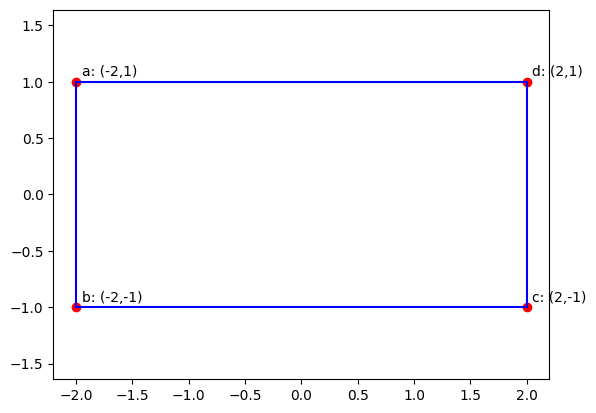

{'b': Point2D(-2, -1),
 'c': Point2D(2, -1),
 'd': Point2D(2, 1),
 'a': Point2D(-2, 1)}

In [128]:
vertices = [(-2, -1), (2, -1), (2, 1), (-2, 1)]
labels = string.ascii_lowercase[:len(vertices)]
labels = list(labels[1:] + labels[:1])
rect = Polygon(*[Point(v) for v in vertices])
plot_polygon(rect, labels)
verts, lines = verts_and_lines(labels, rect)
verts

In [129]:
corner_pairs = [('a', 'c'), ('b', 'd')]
f = Function('f')(x)
traj = y - f
traj_expr = f
traj_expr

In [130]:
example = """bound13_rect_function: LEMMA
    FORALL(f:[real-> real],xo,yo:real):
    derivable?[real](f) AND
    (FORALL(x:real): deriv[real](f)(x) >= 0) AND
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (yo - f(x) + 1 >= 0) AND
     (yo - f(x) - 1 <= 0)) AND
    xo + 2 >= x AND xo - 2 <= x)
    IMPLIES
    ((yo - f(xo - 2) - 1 >= 0) AND
     (yo - f(xo + 2) + 1 <= 0)) OR
    ((yo - f(xo - 2) + 1 >= 0) AND
     (yo - f(xo + 2) - 1 <= 0)) OR
    ((yo - f(xo + 2) - 1 >= 0) AND
     (yo - f(xo - 2) + 1 <= 0)) OR
    ((yo - f(xo + 2) + 1 >= 0) AND
     (yo - f(xo - 2) - 1 <= 0))
"""

In [131]:
lines

In [132]:
traj_expr

In [133]:
min([v.x for v in verts.values()])

In [134]:
left_offset = min([v.x for v in verts.values()])
left_offset

In [135]:
right_offset = max([v.x for v in verts.values()])
right_offset

In [136]:
premise = generate_premise(lines, traj_expr)
explicit = generate_explicit_disjunction(corner_pairs, traj, verts)

In [137]:
premise

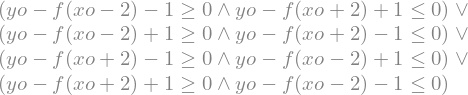

In [138]:
explicit

In [139]:
print(construct_lemma(verts, 
                      premise, 
                      explicit, "bound13_rect_function", 
                      deriv_clause1=">= 0"))

bound13_rect_function: LEMMA
    FORALL(f:[real-> real],xo,yo:real):
    derivable?[real](f) AND
    (FORALL(x:real): deriv[real](f)(x) >= 0) AND
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (yo - f(x) + 1 >= 0) AND
     (yo - f(x) - 1 <= 0)) AND
    xo + 2 >= x AND xo + -2 <= x)
    IMPLIES
    ((yo - f(xo - 2) - 1 >= 0) AND
     (yo - f(xo + 2) + 1 <= 0)) OR
    ((yo - f(xo - 2) + 1 >= 0) AND
     (yo - f(xo + 2) - 1 <= 0)) OR
    ((yo - f(xo + 2) - 1 >= 0) AND
     (yo - f(xo - 2) + 1 <= 0)) OR
    ((yo - f(xo + 2) + 1 >= 0) AND
     (yo - f(xo - 2) - 1 <= 0))



In [142]:
import difflib
diff = difflib.ndiff(example.splitlines(), construct_lemma(verts, premise, explicit, 
                                                           "bound13_rect_function", 
                                                           deriv_clause1=">= 0").splitlines())
print('\n'.join(diff))

  bound13_rect_function: LEMMA
      FORALL(f:[real-> real],xo,yo:real):
      derivable?[real](f) AND
      (FORALL(x:real): deriv[real](f)(x) >= 0) AND
      (EXISTS (x : real) :
      ((-x + xo + 2 >= 0) AND
       (-x + xo - 2 <= 0) AND
       (yo - f(x) + 1 >= 0) AND
       (yo - f(x) - 1 <= 0)) AND
-     xo + 2 >= x AND xo - 2 <= x)
?                         -

+     xo + 2 >= x AND xo + -2 <= x)
?                        ++

      IMPLIES
      ((yo - f(xo - 2) - 1 >= 0) AND
       (yo - f(xo + 2) + 1 <= 0)) OR
      ((yo - f(xo - 2) + 1 >= 0) AND
       (yo - f(xo + 2) - 1 <= 0)) OR
      ((yo - f(xo + 2) - 1 >= 0) AND
       (yo - f(xo - 2) + 1 <= 0)) OR
      ((yo - f(xo + 2) + 1 >= 0) AND
       (yo - f(xo - 2) - 1 <= 0))


In [143]:
# Create an HtmlDiff object
differ = difflib.HtmlDiff()

# Generate HTML diff
html_diff = differ.make_file(example.splitlines(), construct_lemma(verts, premise, explicit, 
                                                                   "bound13_rect_function", 
                                                                   deriv_clause1=">= 0",
                                                                   ).splitlines())
# Save the result as an HTML file
with open("diff_output.html", "w") as file:
    file.write(html_diff)

print("HTML diff saved as 'diff_output.html'")

HTML diff saved as 'diff_output.html'


## Everything you need for a `proveit` file?

In [11]:
preamble = """active_corners  % [ parameters ]
        : THEORY

  BEGIN

  IMPORTING analysis@top

    mvt_gen_ge: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) >= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) >= c*(a-b)

%|- mvt_gen_ge : PROOF
%|- (THEN (SKEEP) (SKEEP)
%|-  (SPREAD (CASE "a=b")
%|-   ((ASSERT)
%|-    (SPREAD (LEMMA "mean_value[real]")
%|-     ((THEN (INST -1 "b" "a" "f") (ASSERT) (SKEEP) (INST -5 "c!1")
%|-       (EXPAND "deriv" -5) (ASSERT) (MULT-BY -5 "a-b") (ASSERT))
%|-      (THEN (LEMMA "connected_real") (PROPAX)))))))
%|- QED mvt_gen_ge


    mvt_gen_le: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) <= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) <= c*(a-b)

%|- mvt_gen_le : PROOF
%|- (POSTPONE)
%|- QED mvt_gen_le


%|- *TCC* : PROOF (assert) QED
"""
close = "\nEND active_corners"

In [12]:
lemmaname = "testlemma"

In [ ]:
premise = generate_premise(lines, traj_expr)
explicit = generate_explicit_disjunction(corner_pairs, traj, verts)

In [13]:
print(construct_lemma(
    verts,
    premise, 
    explicit, 
    lemmaname, 
    deriv_clause1=">= 0"))

NameError: name 'premise' is not defined

In [149]:
# Rectangle proof
builder = ProofBuilder()
rect_proof = builder.build_rect_proof(
    lemmaname,
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
)
print(rect_proof.generate())

%|- testlemma : PROOF
%|- (THEN
%|-  (SKEEP*)
%|-  (LEMMA "mvt_gen_ge")
%|-  (INST?)
%|-  (ASSERT)
%|-  (SPREAD
%|-      (SPLIT -1)
%|-      ((THEN
%|-          (ASSERT)
%|-          (INST -1 "xo + 2" "x")
%|-          (ASSERT)
%|-          (LEMMA "mvt_gen_ge")
%|-          (INST?)
%|-          (ASSERT)
%|-          (SPREAD
%|-              (SPLIT -1)
%|-              ((THEN
%|-                  (INST -1 "x" "xo - 2")
%|-                  (ASSERT)) (PROPAX)))) (PROPAX))))
%|- QED testlemma


In [151]:
builder = ProofBuilder()
rect_proof = builder.build_rect_proof(
    lemmaname,
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
)
proofscript = (preamble + "\n\n" +
    construct_lemma(
        verts,
        premise, 
        explicit, 
        lemmaname, 
        deriv_clause1=">= 0"
    ) + 
    "\n\n" + rect_proof.generate() + 
    close)

In [153]:
print(proofscript)

active_corners  % [ parameters ]
        : THEORY

  BEGIN

  IMPORTING analysis@top

    mvt_gen_ge: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) >= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) >= c*(a-b)

%|- mvt_gen_ge : PROOF
%|- (THEN (SKEEP) (SKEEP)
%|-  (SPREAD (CASE "a=b")
%|-   ((ASSERT)
%|-    (SPREAD (LEMMA "mean_value[real]")
%|-     ((THEN (INST -1 "b" "a" "f") (ASSERT) (SKEEP) (INST -5 "c!1")
%|-       (EXPAND "deriv" -5) (ASSERT) (MULT-BY -5 "a-b") (ASSERT))
%|-      (THEN (LEMMA "connected_real") (PROPAX)))))))
%|- QED mvt_gen_ge


    mvt_gen_le: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) <= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) <= c*(a-b)

%|- mvt_gen_le : PROOF
%|- (POSTPONE)
%|- QED mvt_gen_le


%|- *TCC* : PROOF (assert) QED


testlemma: LEMM

In [155]:
# with open("/Users/nishant/Downloads/proofscript-temp.pvs", "w") as f:
#     f.write(proofscript)

# July 2025

In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
import sys
import os
import string 
from sympy import expand, Line, Polygon, symbols, Point, Function, diff, Symbol, solve, Eq, plot, Piecewise, latex

x, y, xo, yo, alpha = symbols("x y x_O y_O \alpha")

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from pvs_utils import *

## Bounded $f(x)$ 

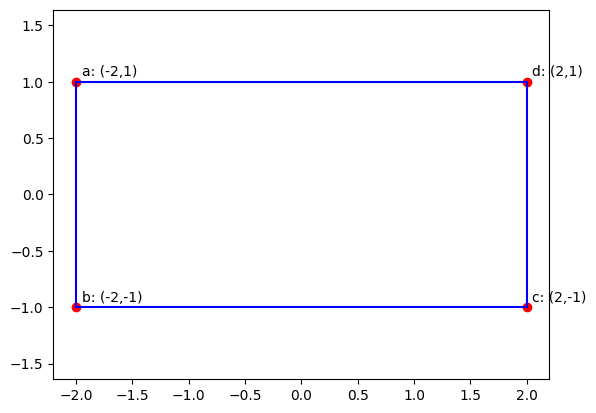

{'b': Point2D(-2, -1),
 'c': Point2D(2, -1),
 'd': Point2D(2, 1),
 'a': Point2D(-2, 1)}

In [25]:
vertices = [(-2, -1), (2, -1), (2, 1), (-2, 1)]
labels = string.ascii_lowercase[:len(vertices)]
labels = list(labels[1:] + labels[:1])
rect = Polygon(*[Point(v) for v in vertices])
plot_polygon(rect, labels)
verts, lines = verts_and_lines(labels, rect)
verts

In [26]:
preamble = """active_corners  % [ parameters ]
        : THEORY

  BEGIN

  IMPORTING analysis@top

    mvt_gen_ge: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) >= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) >= c*(a-b)

%|- mvt_gen_ge : PROOF
%|- (THEN (SKEEP) (SKEEP)
%|-  (SPREAD (CASE "a=b")
%|-   ((ASSERT)
%|-    (SPREAD (LEMMA "mean_value[real]")
%|-     ((THEN (INST -1 "b" "a" "f") (ASSERT) (SKEEP) (INST -5 "c!1")
%|-       (EXPAND "deriv" -5) (ASSERT) (MULT-BY -5 "a-b") (ASSERT))
%|-      (THEN (LEMMA "connected_real") (PROPAX)))))))
%|- QED mvt_gen_ge


    mvt_gen_le: LEMMA
        FORALL(f:[real-> real],c:real):
        (derivable?[real](f) AND
        FORALL(x:real): deriv[real](f)(x) <= c)
        IMPLIES
        FORALL(a,b:real): a>=b IMPLIES
        f(a) - f(b) <= c*(a-b)

%|- mvt_gen_le : PROOF
%|- (POSTPONE)
%|- QED mvt_gen_le


%|- *TCC* : PROOF (assert) QED
"""
close = "\nEND active_corners"

In [27]:
lemmaname = "testlemma"

In [28]:
premise = generate_premise(lines, traj_expr)
explicit = generate_explicit_disjunction(corner_pairs, traj, verts)

In [29]:
print(construct_lemma(
    verts,
    premise, 
    explicit, 
    lemmaname, 
    deriv_clause1=">= 0"))

testlemma: LEMMA
    FORALL(f:[real-> real],xo,yo:real):
    derivable?[real](f) AND
    (FORALL(x:real): deriv[real](f)(x) >= 0) AND
    (EXISTS (x : real) :
    ((-x + xo + 2 >= 0) AND
     (-x + xo - 2 <= 0) AND
     (yo - f(x) + 1 >= 0) AND
     (yo - f(x) - 1 <= 0)) AND
    xo + 2 >= x AND xo + -2 <= x)
    IMPLIES
    ((yo - f(xo - 2) - 1 >= 0) AND
     (yo - f(xo + 2) + 1 <= 0)) OR
    ((yo - f(xo - 2) + 1 >= 0) AND
     (yo - f(xo + 2) - 1 <= 0)) OR
    ((yo - f(xo + 2) - 1 >= 0) AND
     (yo - f(xo - 2) + 1 <= 0)) OR
    ((yo - f(xo + 2) + 1 >= 0) AND
     (yo - f(xo - 2) - 1 <= 0))



In [33]:
# Rectangle proof
builder = ProofBuilder()
rect_proof = builder.build_rect_proof(
    lemmaname,
    "mvt_gen_ge",
    ["xo + 2", "x", "xo - 2"]
    []
)
print(rect_proof.generate())

TypeError: ProofBuilder.build_rect_proof() missing 1 required positional argument: 'spread_cases'

## Speccing out interface

example code: 

```pvs

%|- bound22_rect_function_bounded : PROOF
%|- (THEN (SKEEP*) (SKOLETIN*) (FLATTEN) (SKEEP)
%|-  (SPREAD (CASE "xo-2 >=0")
%|-   ((THEN (LEMMA "mvt_gen_ge_bound") (INST -1 "f" "xo+2" "x" "0")
%|-     (SPREAD (SPLIT -1)
%|-      ((THEN (ASSERT) (LEMMA "mvt_gen_ge_bound") (INST -1 "f" "x" "xo-2" "0")
%|-        (ASSERT) (SKEEP) (INST? :WHERE 1) (ASSERT))
%|-       (PROPAX) (PROPAX) (THEN (SKEEP) (INST? :WHERE 1) (ASSERT)))))
%|-    (THEN (LEMMA "mvt_gen_ge_bound") (INST -1 "f" "xo+2" "x" "0")
%|-     (SPREAD (SPLIT -1)
%|-      ((THEN (ASSERT) (EXPAND "f") (LEMMA "mvt_gen_ge_bound")
%|-        (INST -1 "f" "x" "0" "0") (ASSERT) (SKEEP) (INST? :WHERE 1) (ASSERT))
%|-       (PROPAX) (PROPAX) (THEN (SKEEP) (INST? :WHERE 1) (ASSERT))))))))
%|- QED bound22_rect_function_bounded
```

parameters:
- `xo-2 >= 0`: this is the "unclipped" region of the trajectory
- `mvt_gen_ge_bound`: which lemma to use (should always be the same?)
- `xo + 2, x, xo-2`: inst points 
- `0, inf`: interval range on which this active-corner-case holds 